<a href="https://colab.research.google.com/github/kvik18/new_cafe/blob/main/new_cafe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Исследование рынка заведений общественного питания в Москве

### Описание данных
rest_data:
*	id — идентификатор объекта;
*	object_name — название объекта общественного питания;
*	chain — сетевой ресторан;
*	object_type — тип объекта общественного питания;
*	address — адрес;
*	number — количество посадочных мест.

### План работы
*	Загрузка данных и подготовка их к анализу.  
*	Исследование соотношения видов объектов общественного питания по количеству.   
*	Исследование соотношения сетевых и несетевых заведений по количеству.  
*	Исследование характерных метрик сетевых заведений.  
*	Исследование среднего количества посадочных мест в заведении. 
*	Исследование концентрации объектов общественного питания по улицам и районам Москвы.
*	Выводы.

## Загрузка данных и подготовка их к анализу

In [1]:
# импорт необходимых библиотек
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from plotly import graph_objects as go

In [2]:
# Загрузка файла с данными в переменную rest_data, просмотр 
rest_data = pd.read_csv('rest_data.csv')
rest_data.head(5)

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


In [3]:
# Загрузка файла с данными в переменную rest_data с использованием модуля pathlib:
# data_path = Path('/datasets', 'rest_data.csv')
# rest_data = pd.read_csv(data_path) 
# rest_data.head(5)

In [4]:
# общая информация о данных в файле
rest_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


In [5]:
# подсчет пропусков
rest_data.isna().sum()

id             0
object_name    0
chain          0
object_type    0
address        0
number         0
dtype: int64

In [6]:
# подсчет явных дубликатов
rest_data.duplicated().sum()

0

Тип каждой колонки соответствует данным.  Пропущенные значения и явные дубликаты отсутствуют.
Проверю на неявные дубликаты.

In [7]:
# проверка на неявные дубликаты
d_rows = rest_data.duplicated(subset=['object_name', 'address', 'chain', 'object_type', 'number'], keep='first')
print('Количество неявных дубликатов:', d_rows.sum())
print('Доля строк-дубликатов в таблице:', (d_rows.sum()/rest_data.shape[0]*100).round().astype('str')+'%')

Количество неявных дубликатов: 82
Доля строк-дубликатов в таблице: 1.0%


В данных встречаются 82 повторяющиеся строки, что составляют всего 1%. Удалю эти строки, чтобы очистить данные и избежать возможных проблем при анализе. Удаление небольшой доли из набора не отразится на достоверности оставшихся данных.

In [8]:
# удалю строки с неявными дубликатами
rest_data = rest_data.drop_duplicates(subset=['object_name', 'address', 'chain', 'object_type', 'number'], keep='first')
print('Осталось строк в данных:', rest_data.shape[0])

Осталось строк в данных: 15284


Данные подготовлены к дальнейшему анализу.

## Анализ данных <a id="some_id"></a> 
Исследую соотношение видов объектов общественного питания по количеству. Построю график. <a id="task1"></a> 

In [9]:
# посчитаю количество объектов общественного питания по видам
rest_type = (rest_data
    .groupby('object_type', as_index=False)
    .agg(object_number=('object_name', 'count')) # переименование при агрегации
    .sort_values(by='object_number', ascending=False)
    # столбец с результатами переименую в соответствии с содержанием 
    #.rename(columns={'object_name': 'object_number'}) 
)
# добавлю столбец с отношением
rest_type['%'] = round(rest_type['object_number'] / rest_type['object_number'].sum()*100).astype('str') + '%'
rest_type

,object_type,object_number,%
3,кафе,6071,40.0%
8,столовая,2584,17.0%
7,ресторан,2282,15.0%
6,предприятие быстрого обслуживания,1898,12.0%
0,бар,855,6.0%
1,буфет,577,4.0%
4,кафетерий,395,3.0%
2,закусочная,349,2.0%
5,магазин (отдел кулинарии),273,2.0%


In [10]:
# график распределения объектов общественного питания по видам
fig = px.bar(rest_type, 
             x='object_number', 
             y='object_type',
             title='Соотношение видов объектов общественного питания в Москве', 
             width=900, height=600,
             text='%'
)
fig.update_layout(
    yaxis_title='Тип объекта',
    xaxis_title='Количество')
fig.show()  

Кафе (40%) - самой популярный формат объекта общественного питания в Москве. Далее следуют столовая (17%) и ресторан (15%). Предприятие быстрого питания на четвертом месте (13%). Доли других форматов незначительны.

### Соотношение сетевых и несетевых заведений по количеству. График. <a id="task2"></a> 

In [11]:
# цветовые палитры, доступные в plotly express
# dir(px.colors.qualitative)

In [12]:
# отражу cоотношение сетевых и несетевых заведений по количеству в круговой диаграмме
labels = [
    'Сетевой',
    'Несетевой'
]
fig = go.Figure(data=[go.Pie(labels=labels, 
                             values=rest_data['chain'].value_counts())
                     ])
fig.update_layout(
    title={'text':'Соотношение сетевых и несетевых заведений по количеству'},
    width = 600
    )
fig.show()

График показывает, что в Москве 80% несетевых заведений питания и 20% - сетевых.

### Сетевые объекты общественного питания

In [13]:
# сделаю срез данных по сетевым заведениям
rest_chain_yes = rest_data[rest_data['chain']=='да']
rest_chain_yes.head(5)

,id,object_name,chain,object_type,address,number
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
6,148815,Брусника,да,кафе,"город Москва, переулок Сивцев Вражек, дом 6/2",10
13,22579,Алло Пицца,да,кафе,"город Москва, улица Авиаторов, дом 14",32
16,144107,Суши Wok,да,предприятие быстрого обслуживания,"город Москва, Азовская улица, дом 3",7
18,58565,Тануки,да,ресторан,"город Москва, Большая Академическая улица, дом 65",160


In [14]:
# распределение сетевых объектов общественного питания по видам
rest_type_chain = (rest_chain_yes
    .groupby('object_type', as_index=False)
    .agg({'object_name': 'count'})
    .sort_values(by='object_name', ascending=False)
    # столбец с результатами переименую в соответствии с содержанием 
    .rename(columns={'object_name': 'object_number'}) 
)
# добавлю столбец с отношением
rest_type_chain['%'] = (rest_type_chain['object_number'] / rest_type_chain['object_number'].sum()*100).round().astype('str') + '%'
rest_type_chain

,object_type,object_number,%
3,кафе,1396,47.0%
6,предприятие быстрого обслуживания,788,27.0%
7,ресторан,543,18.0%
5,магазин (отдел кулинарии),78,3.0%
2,закусочная,56,2.0%
4,кафетерий,52,2.0%
0,бар,37,1.0%
1,буфет,11,0.0%
8,столовая,3,0.0%


In [15]:
# график распределения сетевых объектов общественного питания по видам
fig = px.bar(rest_type_chain, 
             x='object_type', 
             y='object_number', 
             title='Распределение сетевых объектов общественного питания по видам в Москве', 
             color='%', 
             width=900, height=600
)
fig.update_xaxes(tickangle=45)
fig.update_layout(
    xaxis_title='Тип объекта',
    yaxis_title='Количество')
fig.show() 

В сетевом сегменте лидируют кафе - 47%, фастфуд - 27%, рестораны - 18%. Доля остальных заведений общественного питания среди сетевых составляет 6%. Таким образом сетевое распространение характерно  для  кафе, фастфуда и ресторанов.  

А теперь посмотрю, какую долю в каждом виде объектов общественного питания составляют сетевые.

In [16]:
# какую долю в каждом виде объектов составляют сетевые
# объединю таблицу с видами сетевых объектов с таблицей с видами всех объектов 
rest_type_chain = (rest_type_chain
    .merge(rest_type[['object_type', 'object_number']],
           left_on='object_type', right_on='object_type')
)
# переименую колонки
rest_type_chain.columns=['object_type', 'object_chain', '%_chain', 'object_all']

# добавлю колонку с долей сетевых объектов в общем количестве объектов данного вида
rest_type_chain['%_all'] = (rest_type_chain['object_chain'] / rest_type_chain['object_all']*100).round()
# отсортирую по доле, запишу в виде %
rest_type_chain = rest_type_chain.sort_values(by='%_all', ascending=False)
rest_type_chain

,object_type,object_chain,%_chain,object_all,%_all
1,предприятие быстрого обслуживания,788,27.0%,1898,42.0
3,магазин (отдел кулинарии),78,3.0%,273,29.0
2,ресторан,543,18.0%,2282,24.0
0,кафе,1396,47.0%,6071,23.0
4,закусочная,56,2.0%,349,16.0
5,кафетерий,52,2.0%,395,13.0
6,бар,37,1.0%,855,4.0
7,буфет,11,0.0%,577,2.0
8,столовая,3,0.0%,2584,0.0


In [17]:
# график долей сетевых объектов в каждом виде объектов общественного питания
rest_type_chain['object_chain'] = rest_type_chain['object_chain'].astype('str')
rest_type_chain.rename(columns={'object_chain': 'Количество'}, inplace = True)
fig = px.bar(rest_type_chain, 
             x='object_type', 
             y='%_all',
             title='Доли сетевых заведений среди видов объектов общественного питания в Москве', 
             color='Количество', 
             width=900, height=600
)
fig.update_xaxes(tickangle=45)
fig.update_layout(
    xaxis_title='Тип объекта',
    yaxis_title='Доли сетевых объектов') 
fig.show()

Самые высокие доли сетевых заведений среди объектов общественного питания имеют:  
1. предприятия быстрого обслуживания	41%
2. отделы кулинарии в магазинах	29%  
3. рестораны	24%
4. кафе	23%
5. закусочные	16%
6. кафетерии	13%  
Доли сетевых объектов других типов незначительны.

Таким образом, для предприятий быстрого обслуживания, отделов кулинарии в магазинах, ресторанов и кафе характерно сетевое распространение.

### Числовые характеристики сетевых заведений

Посмотрю на числовые характеристики и их разброс выборок посадочных мест самых распространенных видов сетевых заведений -  кафе, предприятий быстрого обслуживания, ресторанов. 
Визуализирую распределение посадочных мест и найду диапазон самых распространённых значений.

In [18]:
# Числовые характеристики и их разброс выборки посадочных мест сетевых кафе
df_cafe = rest_chain_yes[rest_chain_yes['object_type'] == "кафе"]
df_cafe['number'].describe()

count    1396.000000
mean       47.426934
std        44.731453
min         0.000000
25%        20.000000
50%        40.000000
75%        60.000000
max       456.000000
Name: number, dtype: float64

Есть сетевые кафе без посадочных мест, максимум 456 посадочных мест. Медиана и среднее 47 и 40 соответственно. Стандартное отклонение велико: 44, значит в наборе данных могут быть серьёзные аномалии или выбросы.

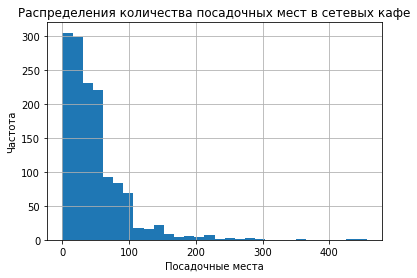

In [19]:
# гистограмма распределения количества посадочных мест в сетевых кафе
df_cafe.hist('number', bins=30)
plt.title('Распределения количества посадочных мест в сетевых кафе')
plt.xlabel('Посадочные места')
plt.ylabel('Частота')
plt.show()

Среди сетевых кафе преобладают заведения до 30 посадочных мест. 30-60 и 60-100 - следующие по распространенности форматы объектов.

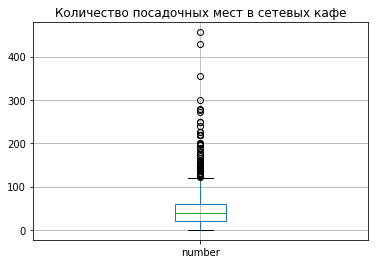

In [20]:
# диаграмма размаха
df_cafe.boxplot('number')
plt.title('Количество посадочных мест в сетевых кафе')
plt.show()

0-120 посадочных мест для сетевого кафе - ориентировочная граница нормальных значений. Всё, что лежит за ней, считается выбросом.

In [21]:
# Числовые характеристики и их разброс выборки посадочных мест сетевых предприятий быстрого обслуживания
df_fastf = rest_chain_yes[rest_chain_yes['object_type'] == "предприятие быстрого обслуживания"]
df_fastf['number'].describe()

count    788.000000
mean      40.319797
std       50.738879
min        0.000000
25%        8.000000
50%       25.000000
75%       52.000000
max      580.000000
Name: number, dtype: float64

Есть сетевые предприятия быстрого обслуживания без посадочных мест, максимум - 580 посадочных мест. Медиана и среднее 25 и 40 соответственно. Стандартное отклонение велико: 50, значит в наборе данных могут быть серьёзные аномалии или выбросы.

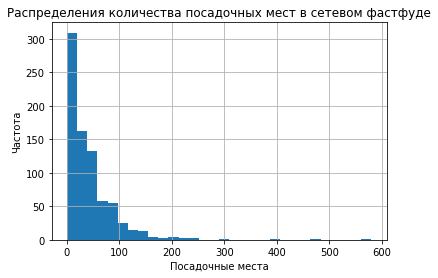

In [22]:
# гистограмма распределения количества посадочных мест в сетевых предприятиях быстрого обслуживания
df_fastf.hist('number', bins=30)
plt.title('Распределения количества посадочных мест в сетевом фастфуде')
plt.xlabel('Посадочные места')
plt.ylabel('Частота')
plt.show()

Среди сетевого фастфуда преобладают заведения до 25 посадочных мест. 25-50 и 50-100 - следующие по распространенности форматы объектов.

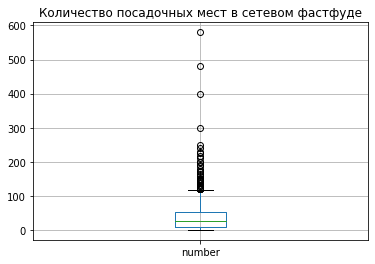

In [23]:
# диаграмма размаха для сетевого фастфуда
df_fastf.boxplot('number')
plt.title('Количество посадочных мест в сетевом фастфуде')
plt.show()

0-120 посадочных мест для сетевого предприятия быстрого обслуживания - ориентировочная граница нормальных значений. Всё, что лежит за ней, считается выбросом.

In [24]:
# Числовые характеристики и их разброс выборки посадочных мест сетевого ресторана
df_rest = rest_chain_yes[rest_chain_yes['object_type'] == "ресторан"]
df_rest['number'].describe()

count    543.000000
mean     100.362799
std       74.442225
min        0.000000
25%       50.000000
50%       89.000000
75%      137.000000
max      500.000000
Name: number, dtype: float64

Есть сетевые рестораны без посадочных мест, максимум 500 посадочных мест. Медиана и среднее 89 и 100 соответственно. Стандартное отклонение велико: 74, значит в наборе данных могут быть серьёзные аномалии или выбросы.

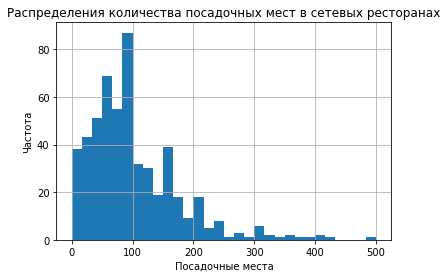

In [25]:
# гистограмма распределения количества посадочных мест в сетевых ресторанах
df_rest.hist('number', bins=30)
plt.title('Распределения количества посадочных мест в сетевых ресторанах')
plt.xlabel('Посадочные места')
plt.ylabel('Частота')
plt.show()

Среди сетевых ресторанов преобладают заведения на 85-100 посадочных мест. Большинство сетевых ресторанов можно разделить на 2 основные группы: до 100 и от 100 до 230 посадочных мест.

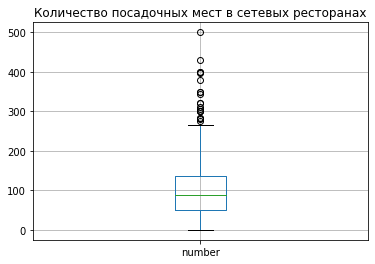

In [26]:
# диаграмма размаха для сетевых ресторанов
df_rest.boxplot('number')
plt.title('Количество посадочных мест в сетевых ресторанах')
plt.show()

0-270 посадочных мест для сетевого ресторана - ориентировочная граница нормальных значений. Всё, что лежит за ней, считается выбросом.

Как видно из графиков выше, в данных о рапределении посадочных мест в заведениях разных видов есть серьезные выбросы. Медиана устойчива к выбросам, поэтому вычислю медиану количества посадочных мест объектов для каждой сети.

In [27]:
# вычислю медиану количества посадочных мест объектов для каждой сети
rest_chain_number = (rest_chain_yes
    .groupby('object_name', as_index=False)
    .agg({'object_name': 'count', 'number': 'median'})
)
rest_chain_number.sort_values(by='object_name', ascending=False).head(10)

,object_name,number
30,155,45.0
702,141,50.0
127,122,41.5
418,121,75.0
195,86,16.0
653,84,21.0
384,82,15.0
428,65,0.0
629,61,6.0
473,50,20.0


In [28]:
# Посчитаю 95-й и 99-й перцентили для количества объектов сети и количества посадочных мест сети
print("95 и 99 перцентили количества объектов сети:", np.percentile(rest_chain_number['object_name'], [95, 99])) 
print("95 и 99 перцентили медианного количества посадочных мест сети:", np.percentile(rest_chain_number['number'], [95, 99]))

95 и 99 перцентили количества объектов сети: [12.   64.08]
95 и 99 перцентили медианного количества посадочных мест сети: [154.55 262.32]


In [29]:
# диаграмма рассеяния количества объектов в сети и медианного числа посадочных мест
fig = px.scatter(rest_chain_number, 
                 x="number", 
                 y="object_name",
                 title='Количество объектов в сети и медианное число мест в них', 
                 width=900, height=600
)
fig.update_layout(
    xaxis_title='Число посадочных мест',
    yaxis_title='Количество объектов в сети')

# добавлю на график линии 95%-перцентилей
fig.add_hline(y=np.percentile(rest_chain_number['object_name'], 95), line_width=2, line_dash="dash", line_color="red")
fig.add_vline(x=np.percentile(rest_chain_number['number'], 95), line_width=2, line_dash="dash", line_color="red")
fig.show()

95% сетей состоят не более, чем из 12 заведений.  
95% сетевых заведений располагают не более чем 155 посадочными местами.  
1% сетей имеет более 64 заведений.  
1% сетевых заведений располагают более чем 262 посадочными местами.

### Среднее количество посадочных мест для каждого вида объекта

In [30]:
# медианное количество посадочных мест для каждого вида объектов общественного питания
rest_type_number = (rest_data
    .groupby('object_type', as_index=False)
    .agg({'number': 'median'})
    .sort_values(by='number', ascending=False)
)
# переведу значение посадочных мест в целочисленное 
rest_type_number['number'] = rest_type_number['number'].round().astype('int')
rest_type_number

,object_type,number
8,столовая,103
7,ресторан,80
0,бар,35
1,буфет,32
3,кафе,30
4,кафетерий,6
6,предприятие быстрого обслуживания,6
2,закусочная,0
5,магазин (отдел кулинарии),0


In [31]:
# график распределения среднего числа посадочных мест по типам объектов общественного питания
# переименую столбцы, чтобы не было проблем с подписями на графике
rest_type_number.columns=['Тип объекта', 'Среднее число посадочных мест']
# добавлю столбец строкового формата для отображения цифр справа
rest_type_number['Количество'] = rest_type_number['Среднее число посадочных мест'].astype('str')
fig = px.bar(rest_type_number, 
             x='Тип объекта', 
             y='Среднее число посадочных мест', 
             title='Распределение среднего числа посадочных мест по типам объектов общественного питания', 
             color='Количество', 
             width=900, height=600
)
fig.update_xaxes(tickangle=45)
fig.show() 

Самое большое среднее количество посадочных мест предоставляет  столовая (103). В ресторане в среднем 80 посадочных мест, в кафе - 30.

### Выделю название улицы в отдельный столбец

In [32]:
# выделю в отдельный столбец информацию об улице из столбца address
#rest_data['street'] = rest_data['address'].str.split(', ').str[1]

# выделю из адреса название улицы
# создам список всех синонимов слова "улица":
street_types = ['улица', 'бульвар', 'проспект', 'переулок', 'шоссе', 
'проезд', 'набережная', 'площадь', 'аллея', 'линия', 'квартал', 'мост', 'тупик', 'просека']

# функция делит адрес на части по запятой с пробелом 
# и проверяет каждую часть на наличие слов из списка street_types
def street_finder(address):
    for address_part in address.split(', '):
        for street_type in street_types:
            if address_part.lower().find(street_type)!= -1:
                return address_part

# выделю в отдельный столбец информацию об улице из столбца address
rest_data['street'] = rest_data['address'].apply(street_finder)
rest_data.sample(5)

,id,object_name,chain,object_type,address,number,street
6089,23888,ТЕРЕМОК,да,буфет,"город Москва, улица Миклухо-Маклая, дом 32А",20,улица Миклухо-Маклая
2043,137987,Ордынка,нет,кафе,"город Москва, улица Большая Ордынка, дом 21/16...",80,улица Большая Ордынка
1197,22126,ХАЧАПУРИ,да,ресторан,"город Москва, Украинский бульвар, дом 7",50,Украинский бульвар
14762,221564,Главпирог,нет,кафе,"город Москва, Рождественский бульвар, дом 1",0,Рождественский бульвар
4656,28920,СТОЛОВАЯ ПРИ ГОУ СОШ № 495,нет,столовая,"город Москва, Подольская улица, дом 15",160,Подольская улица


### График топ-10 улиц по количеству объектов

In [33]:
# сгруппирую таблицу по улицам и посчитаю объекты 
top_streets = (rest_data.groupby('street', as_index=False)
    .agg({'object_name': 'count'})
    .sort_values(by='object_name', ascending=False)
    .rename(columns={'object_name': 'object_number'}))
top_streets.head(10)

,street,object_number
1426,проспект Мира,204
1014,Профсоюзная улица,182
686,Ленинградский проспект,172
997,Пресненская набережная,167
399,Варшавское шоссе,165
689,Ленинский проспект,148
1422,проспект Вернадского,128
676,Кутузовский проспект,114
599,Каширское шоссе,111
606,Кировоградская улица,108


In [34]:
# график топ-10 улиц по количеству объектов общественного питания
# переименую столбцы, чтобы не было проблем с подписями на графике
# добавлю столбец строкового формата для отображения цифр
top_10_streets = top_streets.head(10).copy()
top_10_streets.columns=['Улица', 'Количество объектов']
top_10_streets['Количество'] = top_10_streets['Количество объектов'].astype('str')
fig = px.bar(top_10_streets, 
             x='Улица', 
             y='Количество объектов', 
             title='Топ-10 улиц по количеству объектов общественного питания', 
             color='Количество', 
             width=900, height=600
)
fig.update_xaxes(tickangle=45)
fig.show() 

Воспользуюсь источником https://data.mos.ru/opendata и загружу внешнюю информацию о районах Москвы, в которых находятся найденные улицы: https://docs.google.com/spreadsheets/d/19vCJ_UFyUsviX0MDd4ch9LbUoDNm9RV_dMs6y9crWM8/edit?usp=sharing 

In [35]:
from io import BytesIO
import requests
spreadsheet_id = '19vCJ_UFyUsviX0MDd4ch9LbUoDNm9RV_dMs6y9crWM8'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
df = pd.read_csv(BytesIO(r.content))
df.head(5)

,ID,Name,global_id,IsNetObject,OperatingCompany,TypeObject,AdmArea,District,Address,PublicPhone,...,AdmArea_en,District_en,Address_en,PublicPhone_en,SeatsCount_en,SocialPrivileges_en,Longitude_WGS84_en,Latitude_WGS84_en,geodata_center,geoarea
0,Код,Наименование,global_id,Является сетевым,Название управляющей компании,Вид объекта,Административный округ по адресу,Район,Адрес,Контактный телефон,...,AdmArea_en,District_en,Address_en,PublicPhone_en,SeatsCount_en,SocialPrivileges_en,Longitude_WGS84_en,Latitude_WGS84_en,geodata_center,geoarea
1,00151635,СМЕТАНА,637376221,нет,NaN,кафе,Северо-Восточный административный округ,Ярославский район,"город Москва, улица Егора Абакумова, дом 9",PublicPhone:(499) 183-14-10\n\n,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,000077874,Родник,637376331,нет,NaN,кафе,Центральный административный округ,Таганский район,"город Москва, улица Талалихина, дом 2/1, корпус 1",PublicPhone:(495) 676-55-35\n\n,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,000024309,Кафе «Академия»,637376349,нет,NaN,ресторан,Центральный административный округ,Таганский район,"Российская Федерация, город Москва, внутригоро...",PublicPhone:(495) 662-30-10\n\n,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000027429,ГБОУ «Школа № 1430 имени Героя Социалистическо...,637376480,нет,NaN,столовая,Северо-Восточный административный округ,район Лианозово,"город Москва, Угличская улица, дом 17",PublicPhone:(499) 908-06-15\n\n,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
# оставлю во внешней таблице 3 столбца, исправлю стиль названий:
df = df.drop(0)
df = df[['Name', 'District', 'Address']]
df.columns = ['name', 'district', 'address']

# создам список всех синонимов слова "улица":
# street_types = ['улица', 'бульвар', 'проспект', 'переулок', 'шоссе', 
# 'проезд', 'набережная', 'площадь', 'аллея', 'линия', 'квартал', 'мост', 'тупик', 'просека']

# функция делит адрес на части по запятой с пробелом и проверяет каждую часть на наличие слов из списка
# def street_finder(address):
#     for address_part in address.split(', '):
#         for street_type in street_types:
#             if address_part.lower().find(street_type)!= -1:
#                 return address_part

# выделю из адреса внешнего датафрейма название улицы с помощью функции street_finder
df['street'] = df['address'].apply(street_finder)

df.drop_duplicates(inplace = True)
df.head(5)

,name,district,address,street
1,СМЕТАНА,Ярославский район,"город Москва, улица Егора Абакумова, дом 9",улица Егора Абакумова
2,Родник,Таганский район,"город Москва, улица Талалихина, дом 2/1, корпус 1",улица Талалихина
3,Кафе «Академия»,Таганский район,"Российская Федерация, город Москва, внутригоро...",Абельмановская улица
4,ГБОУ «Школа № 1430 имени Героя Социалистическо...,район Лианозово,"город Москва, Угличская улица, дом 17",Угличская улица
5,Брусника,район Арбат,"город Москва, переулок Сивцев Вражек, дом 6/2",переулок Сивцев Вражек


In [37]:
# сгруппирую внешнюю таблицу по улицам и посчитаю объекты и составлю список уникальных районов
df_streets = (df.groupby('street', as_index=False)
    .agg({'name': 'count', 'district': 'unique'})
    .sort_values(by='name', ascending=False)
    .rename(columns={'name': 'object_number'}))
df_streets.head(5)

,street,object_number,district
1443,проспект Мира,252,"[Мещанский район, Останкинский район, Алексеев..."
683,Ленинградский проспект,231,"[район Беговой, район Аэропорт, район Сокол, Х..."
999,Пресненская набережная,207,[Пресненский район]
1015,Профсоюзная улица,203,"[Академический район, район Черёмушки, район Т..."
686,Ленинский проспект,191,"[район Якиманка, Донской район, Гагаринский ра..."


In [38]:
# объединю таблицу top_streets с районами из таблицы df_streets 
top_streets = (top_streets
                  .merge(df_streets[['street', 'district']], 
                         left_on='street', right_on='street')
)
# добавлю колонку с количеством районов, через которые проходит каждая улица
top_streets['district_number'] = top_streets['district'].apply(lambda x: len(x))

In [39]:
# топ-10 улиц по количеству объектов общественного питания с районами Москвы
top_10_streets = top_streets.head(10)
pd.options.display.max_colwidth = 120
top_10_streets

,street,object_number,district,district_number
0,проспект Мира,204,"[Мещанский район, Останкинский район, Алексеевский район, район Свиблово, район Ростокино]",5
1,Профсоюзная улица,182,"[Академический район, район Черёмушки, район Тёплый Стан, район Коньково, Обручевский район, район Ясенево]",6
2,Ленинградский проспект,172,"[район Беговой, район Аэропорт, район Сокол, Хорошёвский район]",4
3,Пресненская набережная,167,[Пресненский район],1
4,Варшавское шоссе,165,"[Донской район, Нагорный район, район Чертаново Южное, район Чертаново Центральное, район Чертаново Северное, район ...",9
5,Ленинский проспект,148,"[район Якиманка, Донской район, Гагаринский район, Ломоносовский район, Обручевский район, район Тропарёво-Никулино,...",8
6,проспект Вернадского,128,"[Ломоносовский район, район Тропарёво-Никулино, район Проспект Вернадского, поселение Вороновское, район Раменки, Га...",6
7,Кутузовский проспект,114,"[район Дорогомилово, район Фили-Давыдково, поселение Краснопахорское]",3
8,Каширское шоссе,111,"[район Москворечье-Сабурово, район Орехово-Борисово Южное, район Нагатино-Садовники, район Орехово-Борисово Северное...",5
9,Кировоградская улица,108,"[район Чертаново Южное, район Чертаново Центральное, район Чертаново Северное]",3


### Число улиц с одним объектом

In [40]:
# выберу из таблицы top_streets улицы с одним объектом:
one_object = top_streets[top_streets['object_number']==1]
one_object.tail(10)

,street,object_number,district,district_number
1742,Зюзинская улица,1,[район Черёмушки],1
1743,Зубарев переулок,1,[Алексеевский район],1
1744,Штурвальная улица,1,[район Южное Тушино],1
1745,Шубинский переулок,1,[район Арбат],1
1746,Щёлковский проезд,1,[район Северное Измайлово],1
1747,Электрический переулок,1,[Пресненский район],1
1748,Зарайская улица,1,[Рязанский район],1
1749,Жуков проезд,1,[Даниловский район],1
1750,Юрловский проезд,1,[район Отрадное],1
1751,Жигулёвская улица,1,[район Кузьминки],1


In [41]:
# Количество улиц с одним объектом
print('Количество улиц с единственным объектом общественного питания:', one_object.shape[0])

Количество улиц с единственным объектом общественного питания: 434


In [42]:
# посмотрю, в каких районах чаще всего встречаются улицы с одним заведением
top_district = (one_object.explode('district')
    .groupby('district', as_index=False)
    .agg({'street': 'count'})
    .sort_values(by='street', ascending=False))
top_district.head(20)

,district,street
97,район Хамовники,22
23,Таганский район,22
3,Басманный район,20
20,Пресненский район,18
24,Тверской район,17
89,район Соколиная Гора,11
40,район Арбат,11
12,Красносельский район,10
51,район Замоскворечье,9
104,район Южное Бутово,9


Первые 10 в списке районов с самым большим количеством улиц с одним заведением - это самый центр Москвы. Здесь много коротких улочек, высокая плотность застройки. Исключение - Южное Бутово. 

Посмотрю, в каких районах расположены топ-10 улиц по числу заведений:

In [43]:
# посмотрю, в каких районах расположены топ-10 улиц
top_10_streets.explode('district')

,street,object_number,district,district_number
0,проспект Мира,204,Мещанский район,5
0,проспект Мира,204,Останкинский район,5
0,проспект Мира,204,Алексеевский район,5
0,проспект Мира,204,район Свиблово,5
0,проспект Мира,204,район Ростокино,5
1,Профсоюзная улица,182,Академический район,6
1,Профсоюзная улица,182,район Черёмушки,6
1,Профсоюзная улица,182,район Тёплый Стан,6
1,Профсоюзная улица,182,район Коньково,6
1,Профсоюзная улица,182,Обручевский район,6


Топ-10 улиц по количеству объектов общественного питания - это, как правило, крупные многокилометровые городские магистрали, проходящие по нескольким районам города. Районы из этих двух списков - это разные районы, за исключением Пресненского, Мещанского районов и Якиманки.  

Улица из топ-10 в Пресненском районе - это не проспект или шоссе, а довольно компактная	Пресненская набережная. На этой улице находится 167 заведений общественного питания! Разгадка: рядом расположен Москва-Сити. С другой стороны в Пресненском районе расположены 18 улиц с одним заведением.  

В Мещанском районе расположены 9 улиц с одним заведением. С другой стороны по этому району проходит лидер топ-10 улиц по количеству объектов общественного питания - Проспект Мира.  

В районе Якиманка берет начало Ленинский проспект - номер 3 в топ-10. В этом районе находятся 7 улиц с единственным заведением.

Таким образом, в одном и том же районе могут встречаться как улицы с большим количеством заведений, так и улицы с одним заведением. Разделить районы по этому признаку нельзя. Давать рекомендации по району расположения заведения, основываясь на анализе районов через количество заведений на улицах я бы не стала.

## Выводы

Исследование рынка объектов общественного притания Москвы показало, что кафе (40%) - самой популярный формат. Далее следуют столовая (17%), ресторан (15%), предприятие быстрого питания (13%). Доли других форматов незначительны.

В Москве 80% несетевых заведений питания и 20% - сетевых.

В сетевом сегменте лидирует по распространенности формат кафе - 47%, предприятия быстрого обслуживания - 27%, рестораны - 18%.  
Самые высокие доли сетевых заведений среди объектов общественного питания имеют:
предприятия быстрого обслуживания 41%
отделы кулинарии в магазинах 29%
рестораны 24%
кафе 23%.
Таким образом, для предприятий быстрого обслуживания, отделов кулинарии в магазинах, ресторанов и кафе характерно сетевое распространение.

Среди сетевых мало заведений с большим количеством посадочных мест.  
* 95% сетевых заведений располагают не более чем 155 посадочными местами.  
* 95% сетей состоят не более, чем из 12 заведений.

Среднее количество посадочных мест по типам объектов:
* столовая	103
* ресторан	80
* бар	35
* буфет	32
* кафе	30
* кафетерий	6
* предприятие быстрого обслуживания	5

Топ-10 улиц по количеству объектов общественного питания:
* проспект Мира 204  
* Профсоюзная улица 183
* Ленинградский проспект	173
* Пресненская набережная	167
* Варшавское шоссе	165
* Ленинский проспект	148
* проспект Вернадского	132
* Кутузовский проспект	114
* Каширское шоссе	112
* Кировоградская улица	110

Топ-10 - это, как правило, крупные многокилометровые городские магистрали, проходящие по нескольким районам города вне центра.  

Улиц, с единственным объектом общественного питания, 434. Больше всего таких улиц находится в центральных районах Москвы.

Но есть районы, в которых встречаются как улицы с большим количеством заведений, так и несколько улиц с одним заведением. Однозначно разделить районы по этому признаку нельзя. Давать рекомендации по району расположения заведения, основываясь на анализе районов через количество заведений на улицах я бы не стала.

Рекомендации:  
Успешное открытие ресторана начинается с двух ключевых факторов:

1. Выбор верной концепции.  
В условиях жесткой конкуренции нужно выделяться, предложить посетителям то, чего еще никто не предлагал. Поэтому идея небольшого кафе на 30 посадочных мест, где гостей должны обслуживать роботы - хороший способ выделить заведение из множества других. Формат небольшого кафе - самый популярный на рынке.

2.  Выбор удачного расположения.  
* Для ресторана нужно место, где высока концентрация целевой аудитории с учетом концепции. Например, молодежное кафе лучше размещать рядом с учебными заведениями и развлекательными центрами; дорогой ресторан – в центре города, а семейное кафе – в спальном микрорайоне.  
* Место должно быть с высоким пешеходным трафиком, чтобы обеспечить кафе дополнительной рекламой.  
* Нужно оценить расположение с точки зрения конкуренции. Идея кафе оригинальнальна, в ней - его преимущество.
* Расположение должно иметь удобную транспортную доступность и парковку.  

Можно порекомендовать разместить кафе на одной из топ-10 улиц, но с учетом целевой аудитории кафе. 

Сможет ли кафе снискать популярность на долгое время, когда все зеваки насмотрятся на роботов-официантов? После привлечения посетителей важны будут многие другие составляющие успешного заведения: кухня, меню, оригинальность, качество, работа персонала, адекватный ценовой диапазон, чистота и многие другие факторы.

Ссылка на презентацию:
https://drive.google.com/file/d/1-JYbpsng4qjAqDK9mnNQ0UXyppldpeXc/view?usp=sharing